# Problem 7 : PSF Deconvolution with Neural Networks - Classical Solutions
In this notebook, we will demonstrate the application of two algorithms to the problem of PSF deconvolution: 
- using a Fast Fourier Transform, which is among the simplest methods
- using the Lucy-Richardson algorithm, the most widely-used method in astrophysics

In [1]:
import sys
sys.path.insert(0, "../")
import os
from glob import glob
import ast
import numpy as np
import matplotlib.pyplot as plt
from utils.display_utils import display
import h5py

plt.style.use("science")

Let's load and look at a small test dataset:

In [2]:
dataset_dir = "./datasets/debug_deconv_dataset"
data_files = glob(f"{dataset_dir}/*.h5")
max_size = 10

for i, f in enumerate(data_files):
	h5_file = h5py.File(f, mode="r")
	if i == 0:
		desc = ast.literal_eval(h5_file["base"].attrs["dataset_descriptor"])
		set_size = desc["set_size"]
		size = min(set_size, max_size)
		npix = desc["npix"]
		rpf = desc["rpf"]
		corrupt = np.empty((size, npix, npix))
		psf = np.empty_like(corrupt)
		truth = np.empty_like(corrupt)
	
	if (i*rpf) >= size:
		break
	
	corrupt[i*rpf:(i+1)*rpf, ...] = h5_file["base"]["corrupt"][:size]
	psf[i*rpf:(i+1)*rpf, ...] = h5_file["base"]["psf"][:size]
	truth[i*rpf:(i+1)*rpf, ...] = h5_file["base"]["truth"][:size]
	
	h5_file.close()

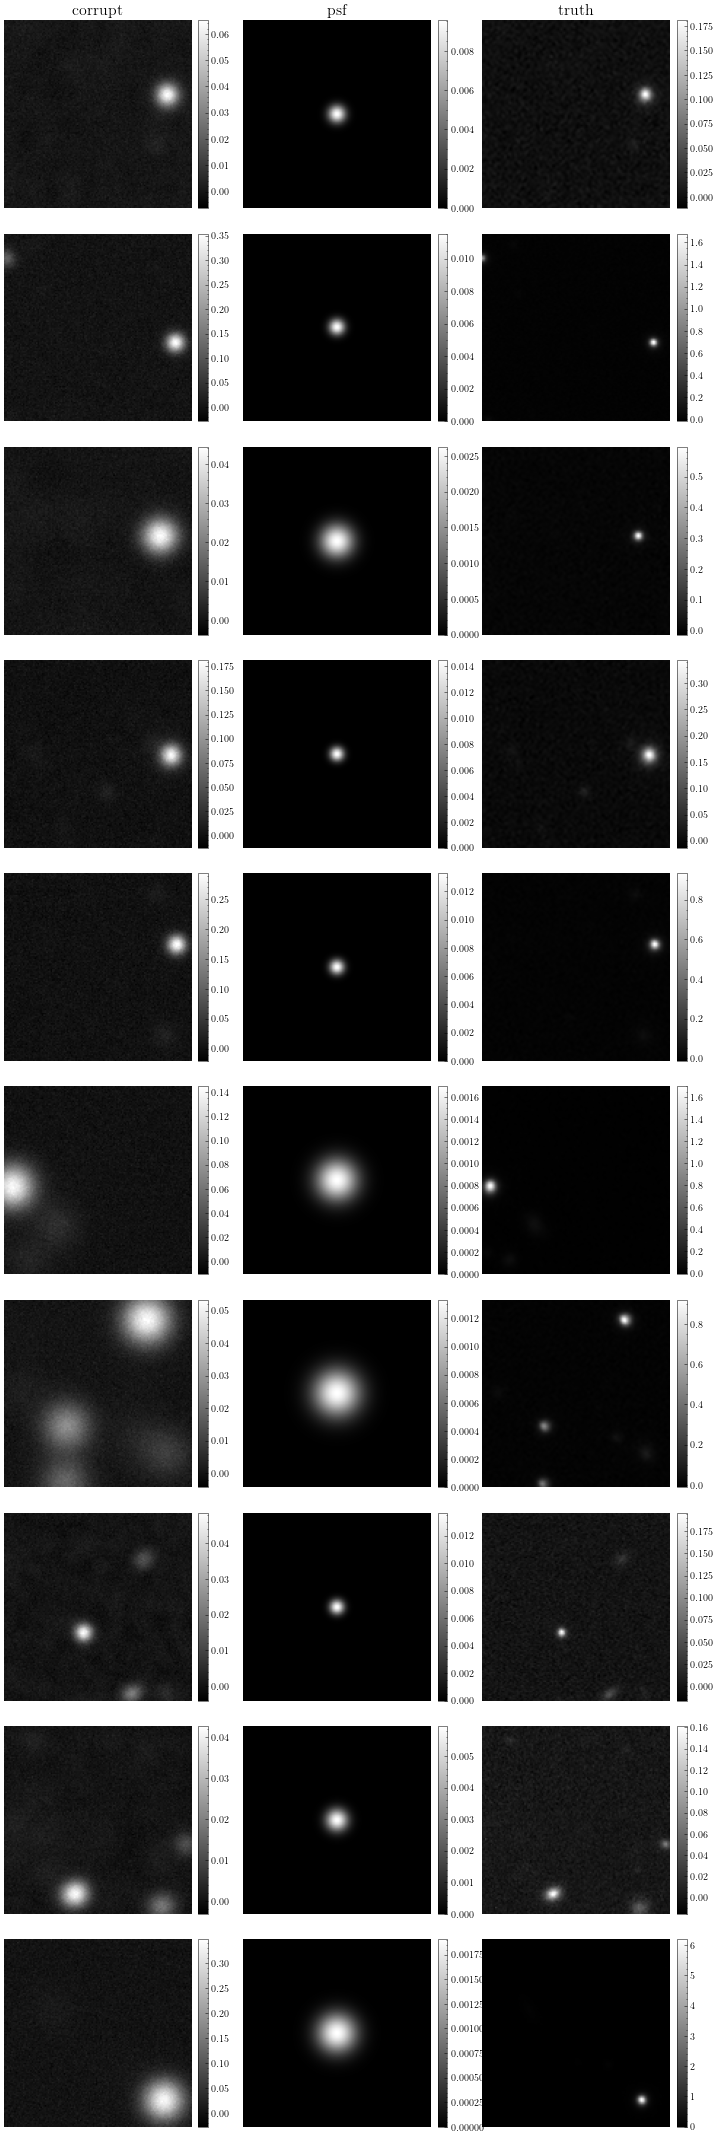

In [3]:
fig, ax = plt.subplots(figsize=(10, size*3), nrows=size, ncols=3)

for i in range(size):
	if i == 0:
		titles = ["corrupt", "psf", "truth"]
	else:
		titles = [None]*3
		
	display(corrupt[i], ax=ax[i, 0], title=titles[0], axis=False)
	display(psf[i], ax=ax[i, 1], title=titles[1], axis=False)
	display(truth[i], ax=ax[i, 2], title=titles[2], axis=False)

plt.tight_layout()
plt.show()

### FFT Deconvolution
The function below is as found in `classical_solution_fft.py`

In [4]:
from scipy.fft import fft2, ifft

def deconvolve_fft(image, psf):
    """
    Deconvolve a PSF from an image and return the sharpened image.

    image: 2d numpy array image
    psf: 2d numpy image with centered point source. Must have odd number of pixels on each side. Point source is centered at the middle of the central pixel.
    """

    # Ensure PSF has odd number of pixels because that's easier
    assert psf.shape[0] % 2 != 0, "psf image must have odd number of pixels"
    assert psf.shape[1] % 2 != 0, "psf image must have odd number of pixels"

    # ensure image has odd number of pixels because that's easier
    if np.any(np.array(image.shape) % 2 == 0):
        print(
            "WARNING: input image has even number of pixles, Im going to remove a pixel from that side."
        )
    image = image[
        0 : image.shape[0] - 1 + (image.shape[0] % 2),
        0 : image.shape[1] - 1 + (image.shape[1] % 2),
    ]

    # Convert image and psf to frequency space
    image_fft = fft2(image)
    psf_fft = fft2(psf, image.shape)

    # Deconvolution operation is division in frequency space
    deconvolved_fft = image_fft / psf_fft

    # Return real space deconvolved image
    deconvolved_image = np.real(ifft(deconvolved_fft))

    return deconvolved_image
    

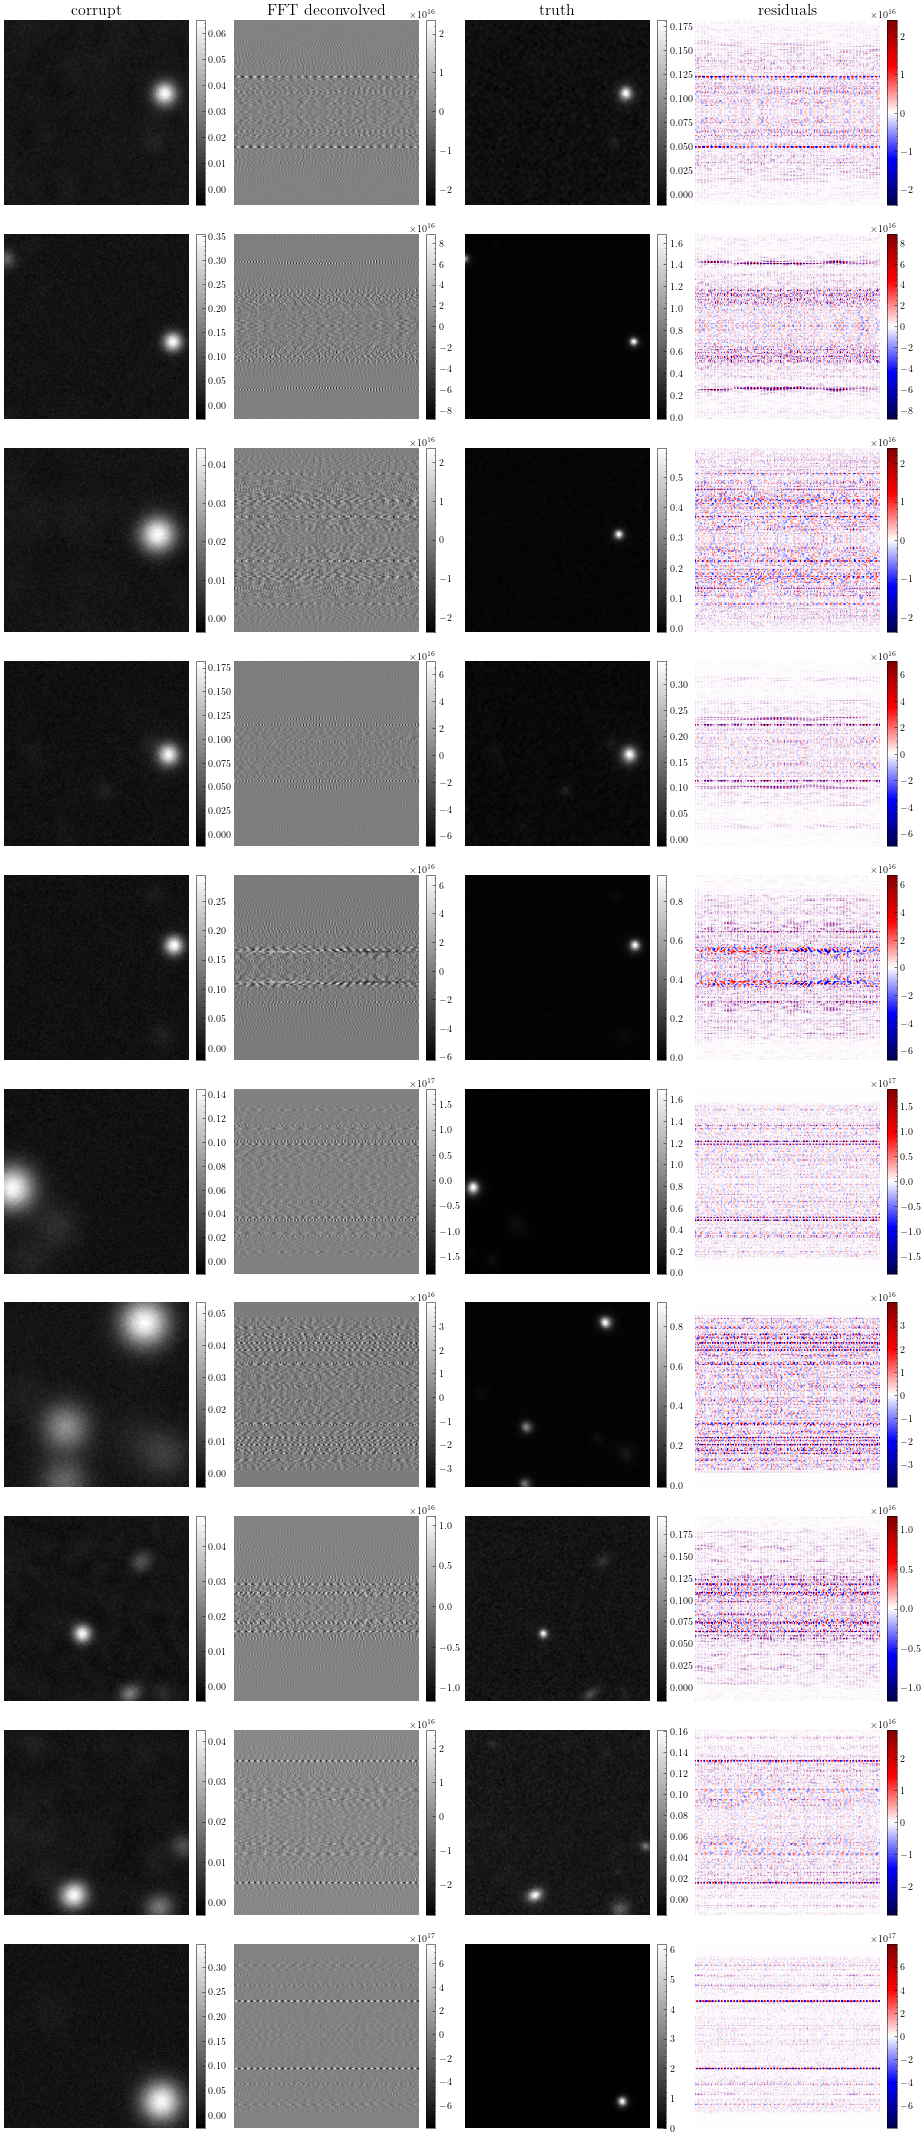

In [5]:
deconvolved_fft = np.empty_like(corrupt)

fig, ax = plt.subplots(figsize=(13, size*3), nrows=size, ncols=4)

for i in range(size):
	if i == 0:
		titles = ["corrupt", "FFT deconvolved", "truth", "residuals"]
	else:
		titles = [None]*4
	
	deconvolved_fft[i] = deconvolve_fft(corrupt[i], psf[i])
	
	display(corrupt[i], ax=ax[i, 0], title=titles[0], axis=False)
	display(deconvolved_fft[i], ax=ax[i, 1], title=titles[1], axis=False)
	display(truth[i], ax=ax[i, 2], title=titles[2], axis=False)
	display(deconvolved_fft[i] - truth[i], ax=ax[i, 3], title=titles[3], axis=False, cmap="seismic", norm="Centered")

plt.tight_layout()
plt.show()

### Lucy-Richardson Deconvolution
The function below is as found in `classical_solution_lucyrichardson.py`

In [6]:
from skimage.restoration import richardson_lucy


def deconvolve_lucyrichardson(image, psf, n_iter=50):
    """
    Deconvolve a PSF from an image and return the sharpened image.

    image: 2d numpy array image
    psf: 2d numpy image with centered point source. Must have odd number of pixels on each side. Point source is centered at the middle of the central pixel.
    n_iter: number of Lucy-Richardson iterations to perform.
    """

    # Ensure PSF has odd number of pixels because that's easier
    assert psf.shape[0] % 2 != 0, "psf image must have odd number of pixels"
    assert psf.shape[1] % 2 != 0, "psf image must have odd number of pixels"

    # Record pixel flux limits from image. These are used to scale to the -1,1 range
    dmax = np.max(image)
    dmin = np.min(image)

    # Perform the LR deconvolution on the scaled image
    deconv = richardson_lucy(
        2 * (image - dmin) / (dmax - dmin) - 1,
        psf,
        num_iter=n_iter,
    )

    # Rescale back to the original flux range and return
    return (deconv + 1) * ((dmax - dmin) / 2) + dmin


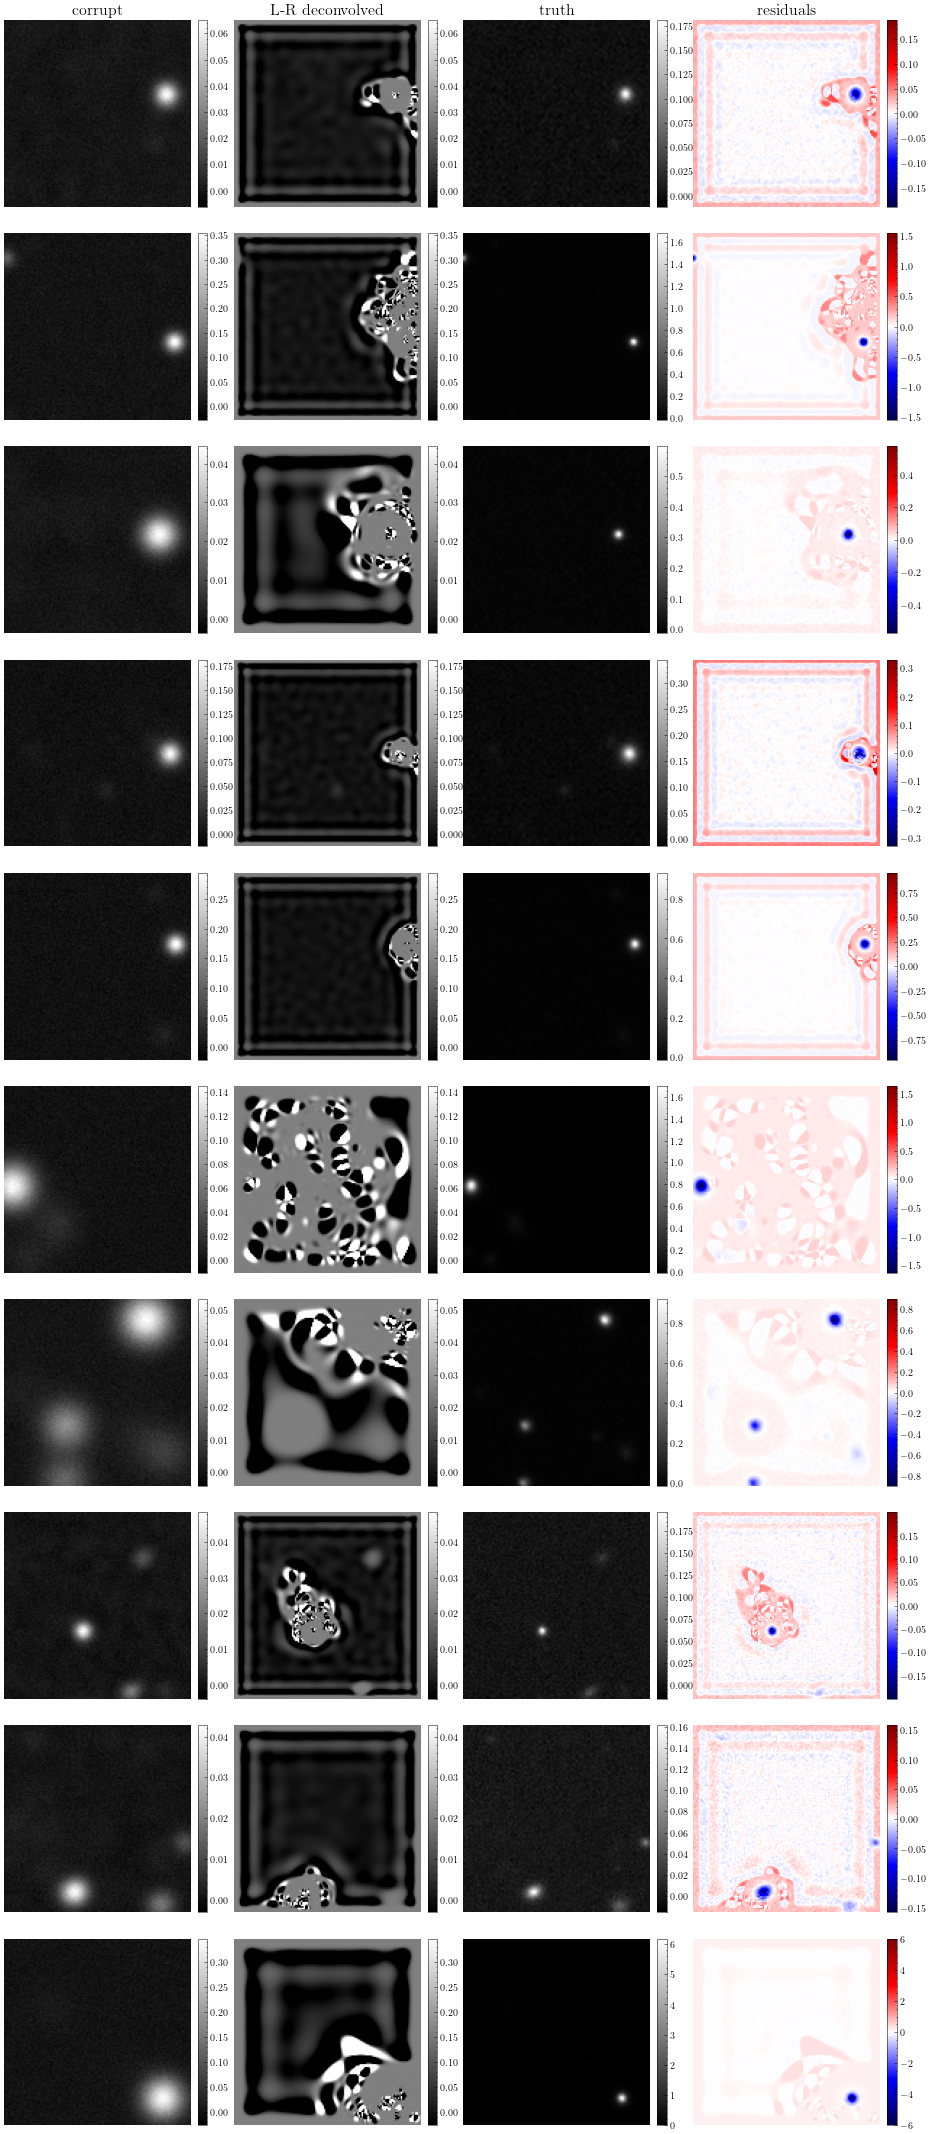

In [7]:
deconvolved_lr = np.empty_like(corrupt)

fig, ax = plt.subplots(figsize=(13, size*3), nrows=size, ncols=4)

for i in range(size):
	if i == 0:
		titles = ["corrupt", "L-R deconvolved", "truth", "residuals"]
	else:
		titles = [None]*4
	
	deconvolved_lr[i] = deconvolve_lucyrichardson(corrupt[i], psf[i])
	
	display(corrupt[i], ax=ax[i, 0], title=titles[0], axis=False)
	display(deconvolved_lr[i], ax=ax[i, 1], title=titles[1], axis=False)
	display(truth[i], ax=ax[i, 2], title=titles[2], axis=False)
	display(deconvolved_lr[i] - truth[i], ax=ax[i, 3], title=titles[3], axis=False, cmap="seismic", norm="Centered")

plt.tight_layout()
plt.show()